#**All Imports**

We disable the eager-execution constrain form tf2 with the compat mode for tf1 to calculate gradients for one layer


In [8]:
import os
import cv2
import timeit
import platform
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

#**CNNs Filters Visualization**

The last easy method of filters **inspection** in convnets is to display the visual patterns that each filter is able to respond to. This can be done with gradient ascent in input space: applying gradient descent to the value of the input image of a convnet so as to maximize the response of a specific filter, starting from a blank input image. The resulting input image would be one that the chosen filter is maximally responsive to.

The process is simple: we will build a **loss function** that maximizes the value of a given filter in a given convolution layer, then we will use **stochastic gradient descent** to adjust the values of the input image so as to maximize this activation value.

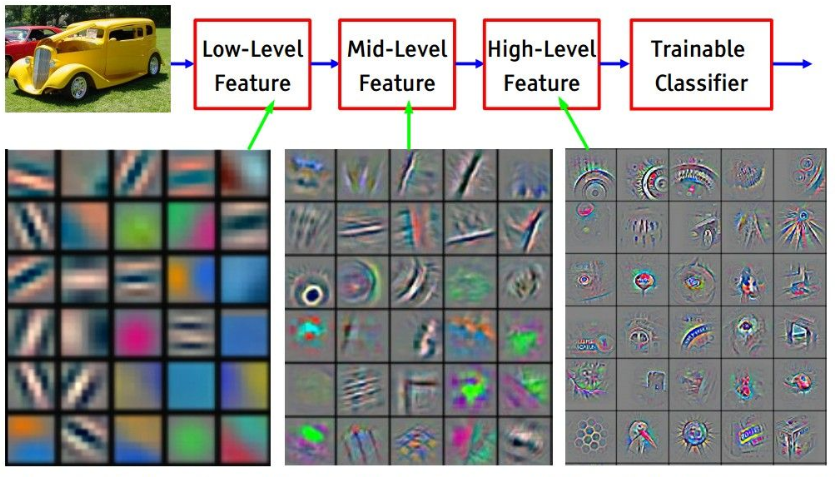

# **All Globals**

In [9]:
layer_name = 'block3_conv1'
filter_index = 0

# **Initializations**

**K.clear_session()** is useful when you're creating multiple models, such as during hyperparameter search or cross-validation. Each model you train adds nodes (potentially numbering in the thousands) to the graph. TensorFlow executes the entire graph whenever you call tf.Session.run() or tf.Tensor.eval(), so your models will become slower and slower to train, and you may also run out of memory. Clearing the session removes all the nodes left over from previous models, freeing memory and preventing slowdown.

In [10]:
K.clear_session()

# All Functions Definition

In [11]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

# **Model Definition** 

This time, we are including the fully-connected layers on top


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

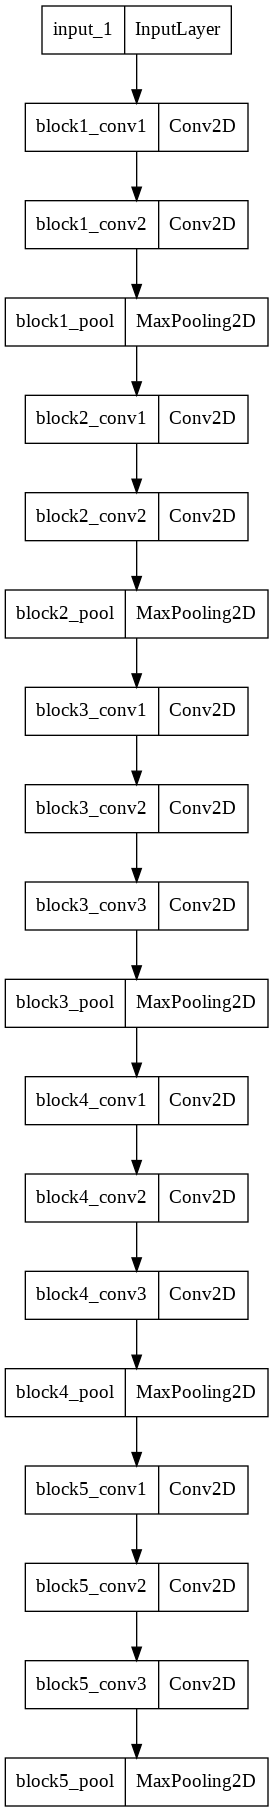

In [12]:
model = VGG16(weights='imagenet', include_top=False)
model.summary()
plot_model(model)

Let's consider a loss for the activation of filter 0 in the layer "block3_conv1" of the VGG16 network, pre-trained on ImageNet:

**model.get_layer:** Retrieves a layer based on either its name (unique) or index. If name and index are both provided, index will take precedence. Indices are based on order of horizontal graph traversal (bottom-up).
In this case: 
retrieves the layer named block3_conv1 which is a tensorflow.keras.layers object

**model.get_layer(...).output:** Retrieves the output tensor(s) of the layer named block3_conv1.


In [13]:
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

To implement **gradient descent**, we will need the gradient of this loss with respect to the model's input. To do this, we will use the gradients function packaged with the backend module of Keras. The call to `gradients` returns a list of tensors (of size 1 in this case)hence we only keep the first element -- which is a tensor.

In [14]:
grads = K.gradients(loss, model.input)[0]

In [15]:
print(model.input)

Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)


A non-obvious trick to use for the gradient descent process to go smoothly is to normalize the gradient tensor, by dividing it by its L2 norm (the square root of the average of the square of the values in the tensor). This ensures that the magnitude of the updates done to the input image is always within a same range. We add 1e-5 before dividing so as to avoid accidentally dividing by 0.

In [16]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Now we need a way to compute the value of the loss tensor and the gradient tensor, given an input image. We can define a Keras backend function to do this: iterate is a function that takes a Numpy tensor (as a list of tensors of size 1) and returns a list of two Numpy tensors: the loss value and the gradient value.

In [17]:
iterate = K.function([model.input], [loss, grads])
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

At this point we can define a Python loop to do stochastic gradient descent: We start from a gray image with some noise, and we run gradient ascent for 40 steps:


In [18]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

The resulting image tensor will be a floating point tensor of shape (1, 150, 150, 3), with values that may not be integer within [0, 
255]. Hence we would need to post-process this tensor to turn it into a displayable image. We do it with the following straightforward utility function:

In [19]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

Now we have all the pieces, let's put them together into a Python function that takes as input a layer name and a filter index, and that returns a valid image tensor representing the pattern that maximizes the activation the specified filter:

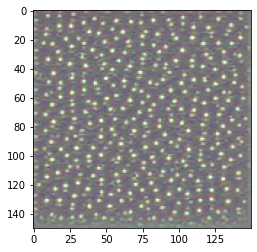

In [20]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

It seems that filter 0 in layer block3_conv1 is responsive to a polka dot pattern.

Now the fun part: we can start visualising every single filter in every layer. For simplicity, we will only look at the first 64 filters in each layer, and will only look at the first layer of each convolution block (block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1). We will arrange the outputs on a 8x8 grid of 64x64 filter patterns, with some black margins between each filter pattern.

These filter visualizations tell us a lot about how convnet layers see the world: each layer in a convnet simply learns a collection of filters such that their inputs can be expressed as a combination of the filters. This is similar to how the Fourier transform decomposes signals onto a bank of cosine functions. The filters in these convnet filter banks get increasingly complex and refined as we go higher-up in the model:

The filters from the first layer in the model (block1_conv1) encode simple directional edges and colors (or colored edges in some cases).
The filters from block2_conv1 encode simple textures made from combinations of edges and colors.
The filters in higher-up layers start resembling textures found in natural images: feathers, eyes, leaves, etc.

# **Homework**

1) Retrain all layers of VGG16 (or another model if you are able) on garbage and dogs datasets and plot some Filters that (contrary to CAM-GRAD and Feature-Map Visualization techniques) do not need to input test images since they are static images yielded by the training process.

2) Check the difference of Filter Visualization for re-trained VGG16 (pretrained in transfer learning on IMAGENET) with all layers retrained and for VGG16 only trained in the last dense layers

3) Plot some Filters of a Simple CNN (i.e. Lenet-Like) trained on Garbage Dataset or Dogs-Cats Dataset. 